In [ ]:
# hide

%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp eda

# Exploratory Data Analysis and Visualization
> Visualising the data extracted from TMDB using graphs and statistics

In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
# exporti

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from pandas import DataFrame
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as tc
import pandas as pd
import os
import concurrent
import requests
import json

## Import the Dataset and Clean Data
The dataset is in CSV format; hence we use the read_csv function from Pandas into the dataframe 'df_all'

In [ ]:
df_all = pd.read_csv('train.csv')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             711 non-null    int64  
 1   adult                  711 non-null    bool   
 2   backdrop_path          704 non-null    object 
 3   belongs_to_collection  224 non-null    object 
 4   budget                 711 non-null    int64  
 5   genres                 711 non-null    object 
 6   homepage               226 non-null    object 
 7   id                     711 non-null    int64  
 8   imdb_id                711 non-null    object 
 9   original_language      711 non-null    object 
 10  original_title         711 non-null    object 
 11  overview               711 non-null    object 
 12  popularity             711 non-null    float64
 13  poster_path            711 non-null    object 
 14  production_companies   711 non-null    object 
 15  produc

We first run a check on the dataset to look for fields with significant null counts.

In [ ]:
df = pd.DataFrame(df_all)
df =df.drop(df.columns[0], axis=1)

df.head()
df.isnull().sum()

adult                      0
backdrop_path              7
belongs_to_collection    487
budget                     0
genres                     0
homepage                 485
id                         0
imdb_id                    0
original_language          0
original_title             0
overview                   0
popularity                 0
poster_path                0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                    0
spoken_languages           0
status                     0
tagline                    0
title                      0
video                      0
vote_average               0
vote_count                 0
dtype: int64

### Removing fields

The following fields have significant null counts, so they will be removed:
> belongs_to_collection, homepage

After that, we determine relevance of the remaining fields in predicting taglines, where our taglines are to be generated based on the content of the movie.

Monetary fields have no relation to the content of the tagline, and are removed: 
> budget, revenue

Movie IDs only give the databases unique identifiers for each movie, and thus have no relation to the content of the tagline. The ID will be used to match the backdrops and posters to the respective movies later on, but for the purpose of EDA and visualization, it will be removed: 
> id, imdb_id

Production details also have no relation to the content of the tagline and are removed:
> production_companies, production_countries

Certain fields are obtained only after the production of the movie, and so have no relation to the generation of the movie tagline and are removed:
> popularity, vote_average, vote_count

'Status' field refers to whether the movie has been released or not, and bears no relation to the tagline of the movie, so it will be removed:
> status

'Runtime' also has no impact on the tagine length, since it does not affect the ideas of the movie.
> runtime

The language fields will be removed, since we are only considering English movies.
>  original_title, original_language, spoken_languages 

In [ ]:
df = df.drop(columns=['budget', 'id', 'imdb_id', 'original_title', \
                        'original_language', 'popularity', 'production_companies', \
                        'production_countries', 'revenue', 'runtime', \
                        'spoken_languages', 'status', 'vote_average', \
                        'vote_count', 'belongs_to_collection', 'homepage'])

### Clean 'video'

The 'video' tag is determined by whether the entry is actually a movie, which are marked as FALSE,  or any other type of video (e.g. sports events, recorded live performances, etc.), which are marked as TRUE. We will remove the "TRUE" entries from the dataframe and leave only the "FALSE" values, since we are predicting taglines for movies only.

Following this, all entries in the 'video' column will be FALSE, so we will drop the column.

In [ ]:
df = df[df.video == False]

df = df.drop(columns=['video'])

### Clean 'genre'

At this point, we will call 'clean_genre()' to perform one-hot encoding to split the categorical data into binary columns. This is necessary as the categorical genre tags need to be converted from json format to something usable for our visualization and training. 

In [ ]:
#export

def clean_genre(df: DataFrame) -> DataFrame:
    
    mlb = MultiLabelBinarizer(sparse_output=True)
    df['genres'] = [[x['name'] for x in eval(list_dict)] for list_dict in df['genres']]
    df1 = df.join(
                pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('genres')),
                index=df.index,
                columns=mlb.classes_))
    return df1

The genres can now be split into individual columns using one-hot encoding, and we will also extract the genre columns at this point for easier reference later on.

In [ ]:
# genre

lc_idx = len(df.columns)-1

df1 = clean_genre(df)

df_genre = df1.iloc[:, lc_idx:len(df1.columns)]
df_genre.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Preparing 'release_date' column

'release_date' will also be parsed as datetime, and we will create 'release_year', 'release_month', 'release_day', and 'release_dow' (day of week) columns for further analysis.

In [ ]:
df1['release_date'] = pd.to_datetime(df1['release_date'], format='%Y-%m-%d') 

df1["release_month"] = ""
df1["release_year"] = ""
df1["release_day"] = ""
df1["release_dow"] = ""

for i in range(len(df1["release_date"])):
    df1.loc[i, "release_month"] = df1.loc[i, "release_date"].month
    df1.loc[i, "release_year"] = df1.loc[i, "release_date"].year
    df1.loc[i, "release_day"] = df1.loc[i, "release_date"].day
    df1.loc[i, "release_dow"] = df1.loc[i, "release_date"].dayofweek

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711 entries, 0 to 710
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype           
---  ------           --------------  -----           
 0   adult            711 non-null    bool            
 1   backdrop_path    704 non-null    object          
 2   overview         711 non-null    object          
 3   poster_path      711 non-null    object          
 4   release_date     711 non-null    datetime64[ns]  
 5   tagline          711 non-null    object          
 6   title            711 non-null    object          
 7   Action           711 non-null    Sparse[int64, 0]
 8   Adventure        711 non-null    Sparse[int64, 0]
 9   Animation        711 non-null    Sparse[int64, 0]
 10  Comedy           711 non-null    Sparse[int64, 0]
 11  Crime            711 non-null    Sparse[int64, 0]
 12  Documentary      711 non-null    Sparse[int64, 0]
 13  Drama            711 non-null    Sparse[int64, 0]
 14  Family    

## Univariate Data Visualisation and Analysis
We will visualize the remaining fields with the appropriate tools to further ascertain their suitability for training our tagline generation model.

We begin by performing univariate visualisation on each field

### 'adult' Column
In this section we will visualize the distribution of values for the 'adult' column. This column consists of boolean values indicating whether the movie is tagged as an adult movie (TRUE) or not (FALSE)

In [ ]:
# adult

print("Total   ", len(df1["adult"]))
print(df1["adult"].value_counts())

Total    711
False    711
Name: adult, dtype: int64


The 'adult' column is (almost) 100% false and will be dropped as there is no correlation to tagline generation.

### Date Columns
In this section we will explore the 'release_date', 'release_year', 'release_month', 'release_day', and 'release_dow' columns.

First, we will only be looking at the distributions of the different components of the date, to help in our visualisation. 

We will start by looking at the distribution of 'release_year' using boxplot, histogram, and violin plot.

min year:	 1915
max year:	 2014
mean year:	 1986.057665260197
median year:	 1994.0
mode year:	 0    2006
dtype: object


Text(0.5, 0, 'release_year')

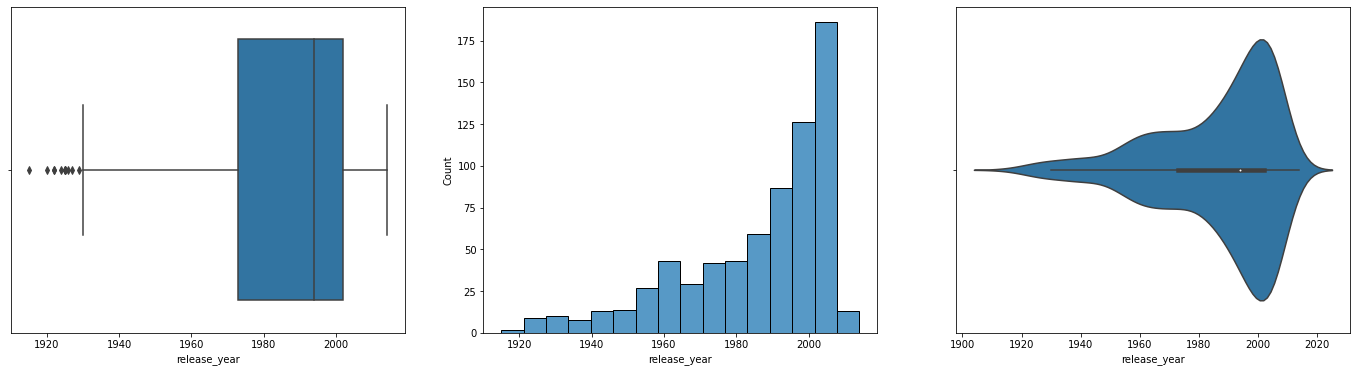

In [ ]:
# release_year 

print("min year:\t", df1["release_year"].min())
print("max year:\t", df1["release_year"].max())
print("mean year:\t", df1["release_year"].mean())
print("median year:\t", df1["release_year"].median())
print("mode year:\t", df1["release_year"].mode())

f, axes = plt.subplots(1, 3, figsize=(24, 6))

g = sb.boxplot(data = df1["release_year"], orient = "h", ax = axes[0])
g.set(yticklabels=[])
g.set_xlabel('release_year')

g = sb.histplot(data = df1["release_year"], ax = axes[1])

g = sb.violinplot(data = df1["release_year"], orient = "h", ax = axes[2])
g.set(yticklabels=[])
g.set_xlabel('release_year')

We can see that our data is skewed to the right with a peak in the early 2000s. The distribution will be useful in identifying text patterns in the taglines generated for the year of release.

Next, we will look at the distribution of 'release_month'. Although numeric, this data is really categorical, so we will make use of Seaborn's catplot.

1     29
2     49
3     54
4     45
5     90
6     76
7     58
8     42
9     69
10    56
11    50
12    93
Name: release_month, dtype: int64


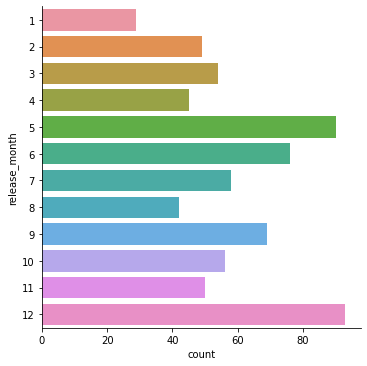

In [ ]:
# release_month 

print(df1["release_month"].value_counts().sort_index())
sb.catplot(y = "release_month", data = df1, kind = "count")

It is evident that the release of movies is well-spread across the months, although the most movies are released in May and December. The release month may be dependent on the intended audience, which in turn could impact the generation of the movie's tagline.

Next, we will look at the distribution of 'release_day':

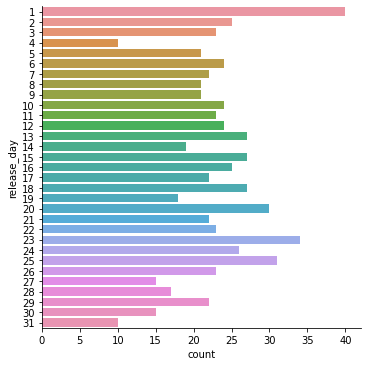

In [ ]:
# release_day

sb.catplot(y = "release_day", data = df1, kind = "count")

The data is well-spread across dates. However, this may not be very useful as certain days (such as 31) only appear in some months, so the information may not be as representative of the trend.

To address this, we will perform data binning on the dataset to provide another perspective. We will split each month into thirds.

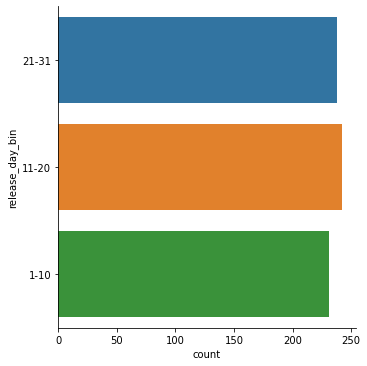

In [ ]:
# release_date binning

df1['release_day_bin'] = ""

for i in range(len(df1)):
    tmpInt = df1.iloc[i, df1.columns.get_loc('release_day')]
    if (tmpInt >= 1 and tmpInt <= 10):
        df1.iloc[i, df1.columns.get_loc('release_day_bin')] = '1-10'
    elif (tmpInt >= 11 and tmpInt <= 20):
        df1.iloc[i, df1.columns.get_loc('release_day_bin')] = '11-20'
    elif (tmpInt >= 21 and tmpInt <= 31):
        df1.iloc[i, df1.columns.get_loc('release_day_bin')] = '21-31'

sb.catplot(y = "release_day_bin", data = df1, kind = "count")

Once binned into groups of thirds, we can see that the spread is relatively even across the thirds of each month. Since there is little variation, we can determine that the release day is not relevant to the generation of the tagline. 

Finally, we will look at the distribution of 'release_dow' (day of week)

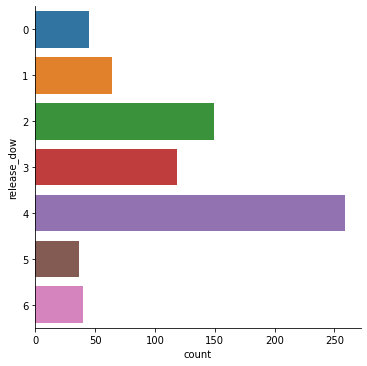

In [ ]:
# release_dow

sb.catplot(y = "release_dow", data = df1, kind = "count")

We see a significant number of movies released on Thursdays. Movies that deviate from this pattern may have different tagline features.

### 'genre' Column
Next, we will look at the 'genre' tag. 

We will first extract the count of each genre to a 2D dataframe. The genres can then be visualised using a barplot.

Action : 179
Adventure : 152
Animation : 16
Comedy : 165
Crime : 153
Documentary : 12
Drama : 391
Family : 39
Fantasy : 75
History : 42
Horror : 62
Music : 18
Mystery : 74
Romance : 130
Science Fiction : 94
TV Movie : 4
Thriller : 222
War : 37
Western : 17


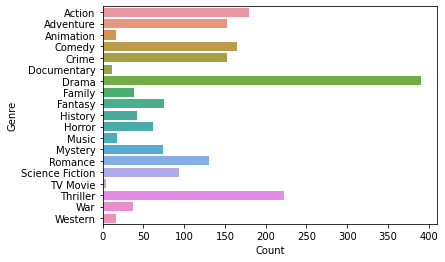

In [ ]:
# count of each genre

df2 = pd.DataFrame(columns=['Genre','Count'])
for var in df_genre:
    df2 = df2.append({'Genre': var}, ignore_index=True)
    df2.iloc[-1, df2.columns.get_loc('Count')] = df_genre[var].sum()
    print(var, ":", df_genre[var].sum())

ax = sb.barplot(x="Count", y="Genre", data=df2)

From this barplot, it is clear that certain genres are far more common than others, such as Drama and Thriller movies. This information is useful as it is expected that genre has a significant impact on the generation of tagline.

Next we will look at the number of genres for each movie. Since we hypothesise that a movie's genre has a significant impact on the generated tagline, the number of genres a movie has will be related to the number of factors determining how the tagline will turn out.

median count:	 3.0


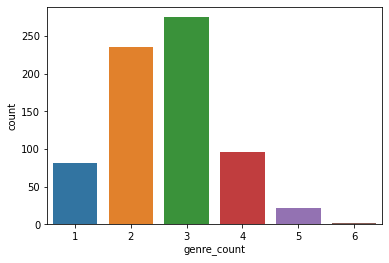

In [ ]:
# count of number of genres for each movie

df1["genre_count"] = 0
for i in range(len(df1)):
    df1.iloc[i, df1.columns.get_loc('genre_count')] = df_genre.iloc[i,:].sum()

ax = sb.countplot(x="genre_count", data=df1)
print("median count:\t", df1["genre_count"].median())

Most movies have multiple genres, though each movie can have only one tagline. Thus the generated tagline must conform to the features of 3 genres on average (median and mode).

### 'overview' Column
A text-based field. We will inspect this field using the number of words in the overview for each movie, followed by identifying the most frequent words. Like genre, this field is expected to have a significant impact on the generation of the tagline.

We will first visualise the distribution of number of words in the overview.

min overview_words:	 12
max overview_words:	 169
mean overview_words:	 48.45428973277075
median overview_words:	 47.0
mode overview_words:	 0    52
dtype: int64


Text(0.5, 0, 'overview_words')

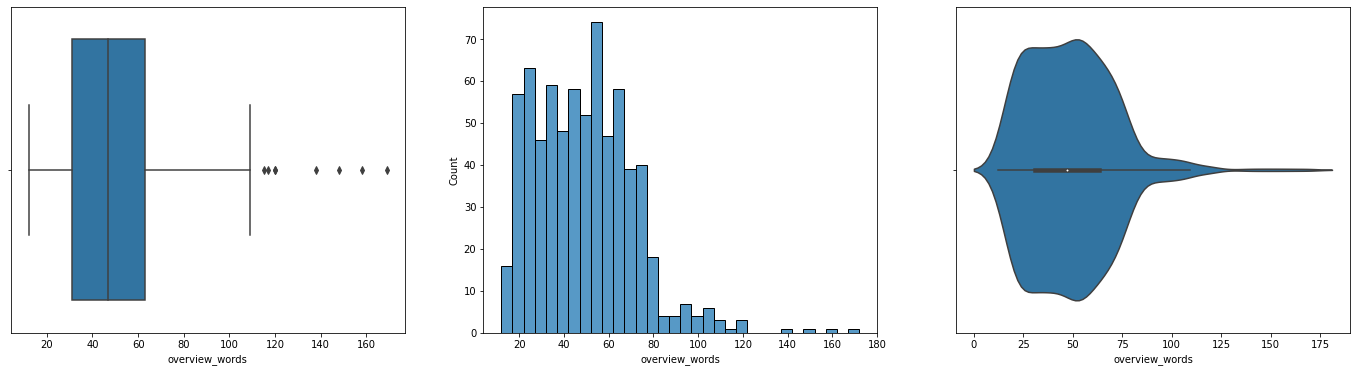

In [ ]:
# number of words in overview

df1["overview_words"] = 0

for i in range(len(df1)):
    tmpStr = df1.iloc[i, df1.columns.get_loc('overview')] 
    res = len(tmpStr.split())
    df1.iloc[i, df1.columns.get_loc('overview_words')]  = res
    
print("min overview_words:\t", df1["overview_words"].min())
print("max overview_words:\t", df1["overview_words"].max())
print("mean overview_words:\t", df1["overview_words"].mean())
print("median overview_words:\t", df1["overview_words"].median())
print("mode overview_words:\t", df1["overview_words"].mode())

f, axes = plt.subplots(1, 3, figsize=(24, 6))

g = sb.boxplot(data = df1["overview_words"], orient = "h", ax = axes[0])
g.set(yticklabels=[])
g.set_xlabel('overview_words')

sb.histplot(data = df1["overview_words"], binwidth=5, ax = axes[1])

g = sb.violinplot(data = df1["overview_words"], orient = "h", ax = axes[2])
g.set(yticklabels=[])
g.set_xlabel('overview_words')

There is a somewhat clear distribution curve for the number of words in the movie overview. Since we know how many words on average each overview has, we can properly set the input size for our model, since it requires fixed-length text inputs.

Next, we will look at the most frequent words in the overview field, by designing a function to extract the n most frequent words from the field.

In [ ]:
#export

#Most frequent word function definition
def freq_words(df, var, num):
    import re
    from collections import Counter

    tmpStr = ""
    for i in range(len(df)):
        tmpStr = tmpStr + " " + re.sub(r'[^\w\s]', '', df.iloc[i, df.columns.get_loc(var)])

    tmpList = tmpStr.lower().split()
    Counter = Counter(tmpList)
    most_freq = Counter.most_common()

    df_freq = pd.DataFrame(most_freq, columns =['Word', 'Count'])
    return df_freq.iloc[:num,:]


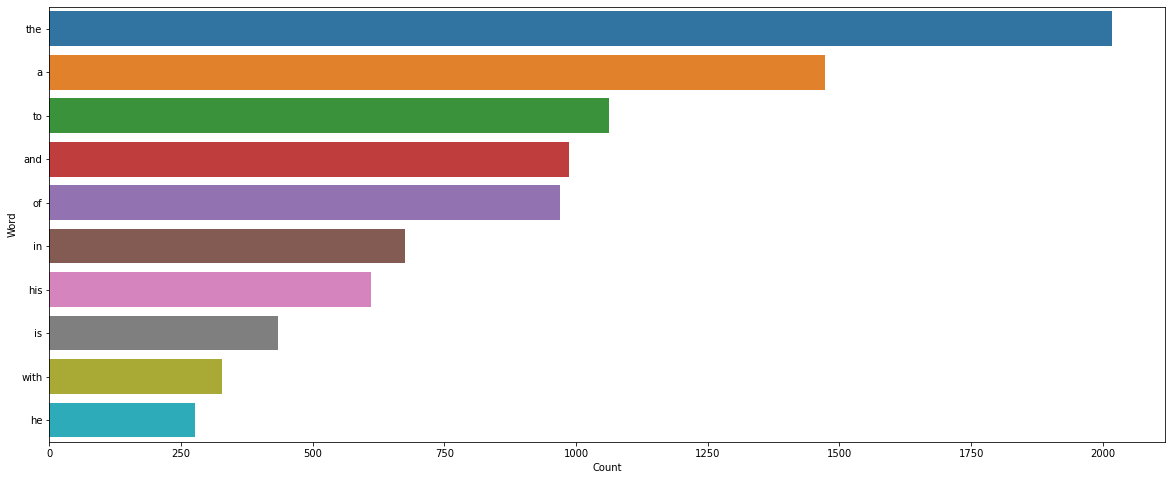

In [ ]:
# Most frequent word

o_top_10 = freq_words(df1, 'overview', 10)

f = plt.figure(figsize=(20, 8)) 
ax = sb.barplot(x="Count", y="Word", data=o_top_10)

As evident in the above plot, most of the most-frequent words contribute little semantic value to the text, belonging to a group of words known as "stopwords", such as "the" and "a". To handle this, we will remove the stopwords by referencing the Natural Language Toolkit's List of Stopwords, and generate the most-frequent words again.

In [ ]:
#export

# Most frequent word without stopwords function definition

def freq_words_sw(df, df_sw, var, num):
    import re
    from collections import Counter

    tmpStr = ""
    for i in range(len(df)):
        tmpStr = tmpStr + " " + re.sub(r'[^\w\s]', '', df.iloc[i, df.columns.get_loc(var)])

    tmpList = tmpStr.lower().split()
    Counter = Counter(tmpList)
    most_freq = Counter.most_common()

    df_freq = pd.DataFrame(most_freq, columns =['Word', 'Count'])
    
    i = 0
    while i < len(df_freq):
        tmpStr = df_freq.iloc[i, df_freq.columns.get_loc('Word')]
        if tmpStr in df_sw.values:
            df_freq = df_freq.drop(index=df_freq.iloc[i].name)
            i = i - 1
        i = i + 1
        
    return df_freq.iloc[:num,:]

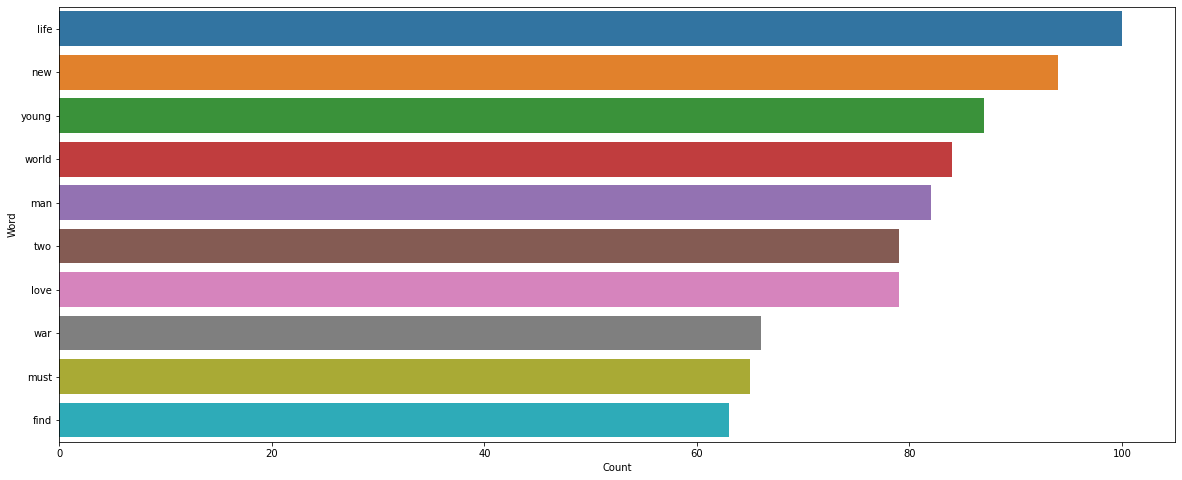

In [ ]:
# import stopwords csv and generate new list

df_sw = pd.read_csv('NLTK_sw.csv', header=None)

o_top_10_sw = freq_words_sw(df1, df_sw, 'overview',10)

f = plt.figure(figsize=(20, 8)) 
ax = sb.barplot(x="Count", y="Word", data=o_top_10_sw)

From here we can see the counts of words with more meaningful contribution to the tagline.

### 'tagline' Column
This is the field to be generated by our model. Key characteristics to look at include length of the tagline (number of words) and words that appear most frequently.

We will inspect this field using the number of words in the tagline for each movie, followed by identifying the most frequent words, accounting for stopwords as well. Like overview, this field is expected to have a significant impact on the generation of the tagline.

We will first visualise the distribution of word counts for the taglines.

min tagline_words:	 1
max tagline_words:	 34
mean tagline_words:	 8.933895921237694
median tagline_words:	 8.0
mode tagline_words:	 0    5
dtype: int64


Text(0.5, 0, 'tagline_words')

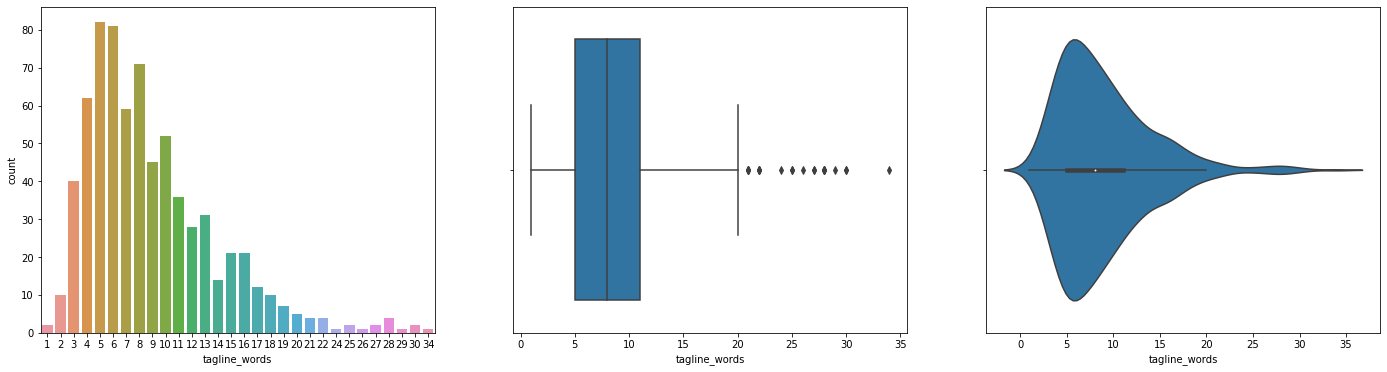

In [ ]:
# number of words in tagline

df1["tagline_words"] = 0

for i in range(len(df1)):
    tmpStr = df1.iloc[i, df1.columns.get_loc('tagline')] 
    res = len(tmpStr.split())
    df1.iloc[i, df1.columns.get_loc('tagline_words')]  = res
    
print("min tagline_words:\t", df1["tagline_words"].min())
print("max tagline_words:\t", df1["tagline_words"].max())
print("mean tagline_words:\t", df1["tagline_words"].mean())
print("median tagline_words:\t", df1["tagline_words"].median())
print("mode tagline_words:\t", df1["tagline_words"].mode())
    

f, axes = plt.subplots(1, 3, figsize=(24, 6))

ax = sb.countplot(x="tagline_words", data=df1,ax = axes[0])

g = sb.boxplot(data = df1["tagline_words"], orient = "h", ax = axes[1])
g.set(yticklabels=[])
g.set_xlabel('tagline_words')

g = sb.violinplot(data = df1["tagline_words"], orient = "h", ax = axes[2])
g.set(yticklabels=[])
g.set_xlabel('tagline_words')

There is a relatively clear distribution curve for the number of words in the movie tagline. This tells us the approximate number of words we should expect to generate for each tagline.

Next, we will look at the most frequent words in the tagline field, using the same functions created to inspect 'overview'.

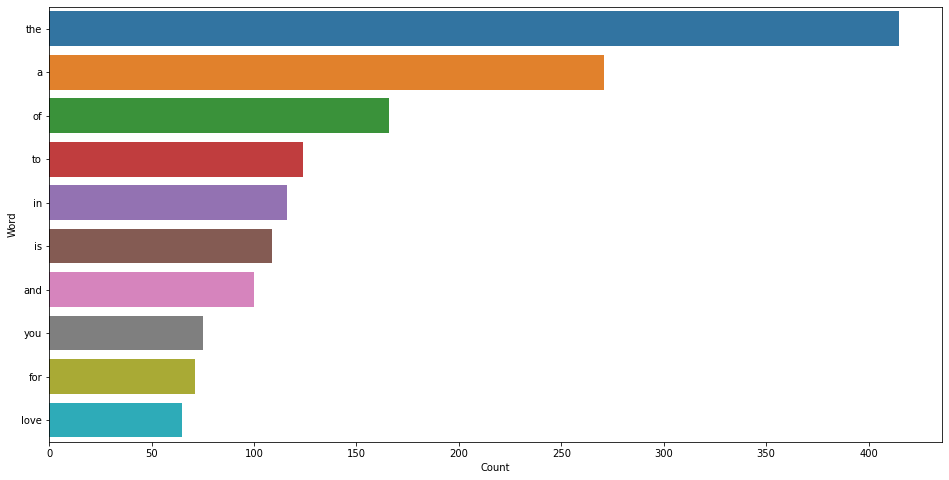

In [ ]:
t_top_10 = freq_words(df1, 'tagline', 10)

f = plt.figure(figsize=(16, 8)) 
ax = sb.barplot(x="Count", y="Word", data=t_top_10)

As with overview, the most-frequent words list from the taglines is dominated by stop-words. We will repeat the count after removing the stopwords.

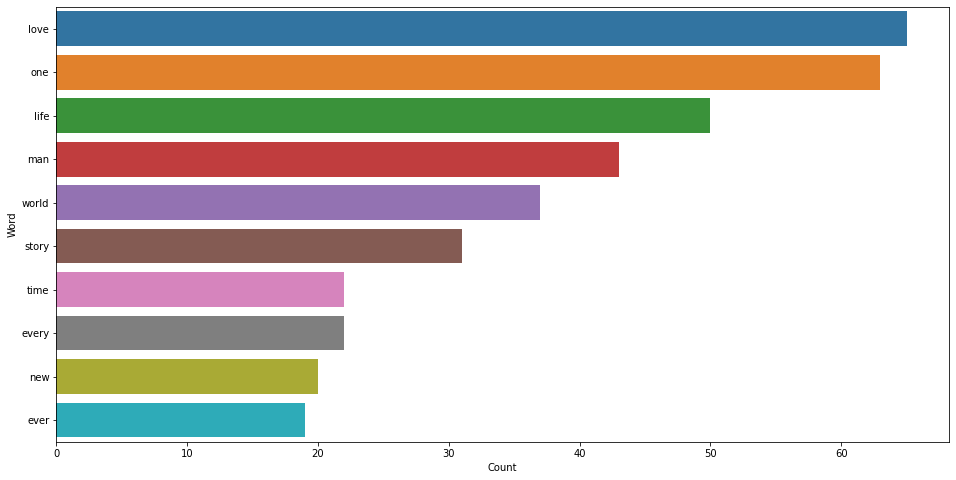

In [ ]:
# generate new list
t_top_10_sw = freq_words_sw(df1, df_sw, 'tagline',10)

f = plt.figure(figsize=(16, 8)) 
ax = sb.barplot(x="Count", y="Word", data=t_top_10_sw)

Once again we have obtained a list with more meaningful words and their frequencies, which gives us an indication of the kinds of words we expect to see when generating taglines.

## Bivariate Data Visualisation and Analysis
We have finished conducting univariate visualisation and analysis. The next step is too perform bivariate visualisation and analysis for relevant pairs of fields.

### 'genre' Correlation
A comparison of the correlation between genres. Since genre is expected to impact the tagline generated, we can expect strongly correlated genres to generate taglines that are more similar to each other. 

<AxesSubplot:>

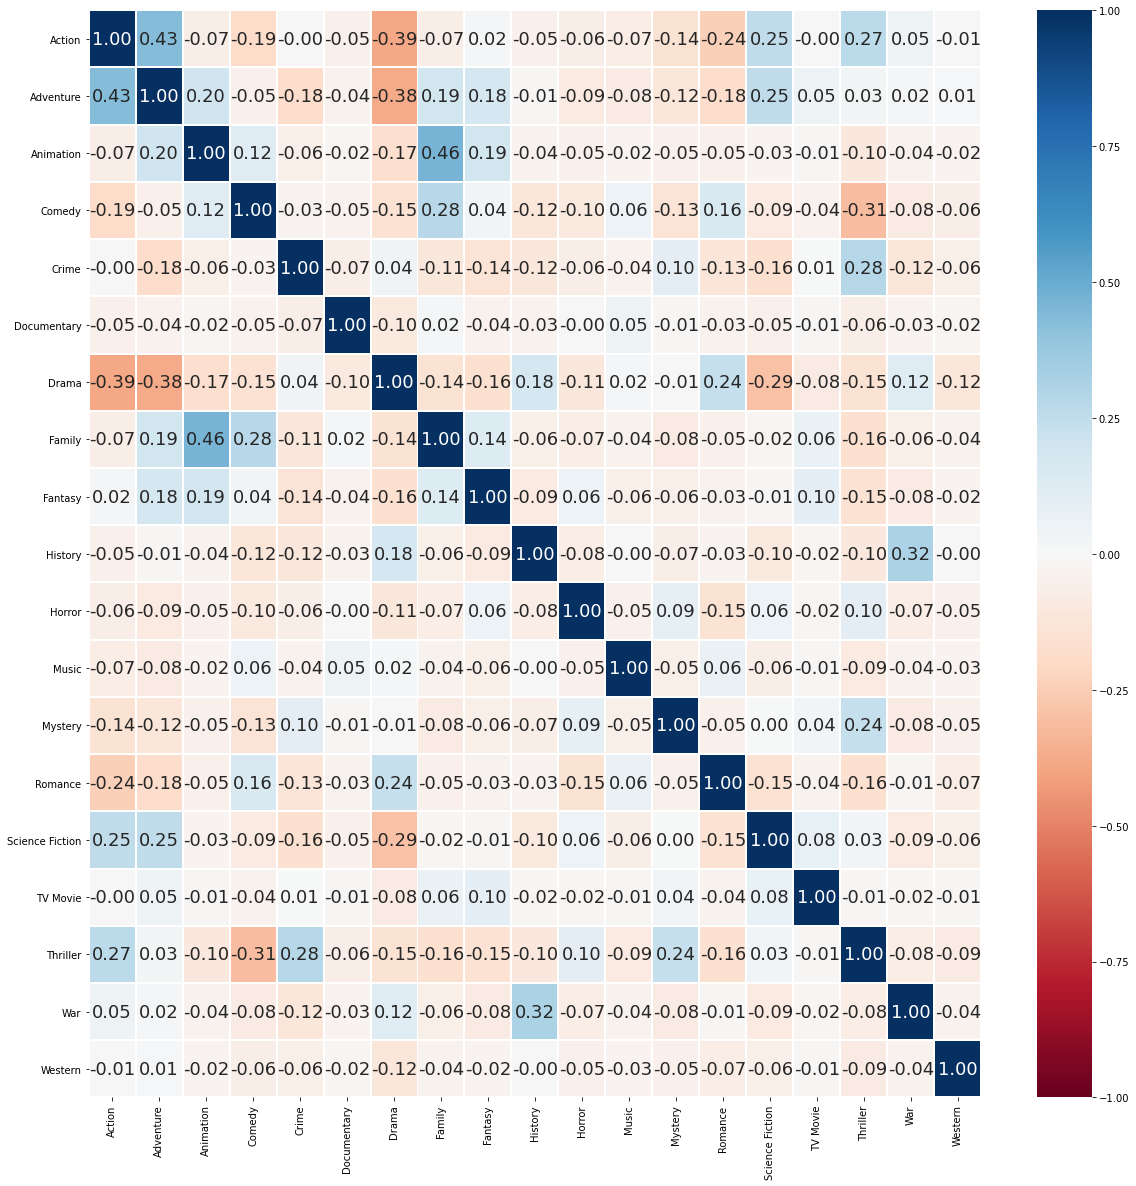

In [ ]:
# Heatmap of the Correlation Matrix

f = plt.figure(figsize=(20, 20))
sb.heatmap(df_genre.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

In this case, we can expect taglines generated for Action and Adventure movies to be more similar to each other than to those generated for Drama movies.

### 'genre' vs 'tagline' length
Comparison of genres against the number of words in the tagline for the movie. This visualisation will provide a guideline to what kind of tagline lengths we can expect to generate for each genre.

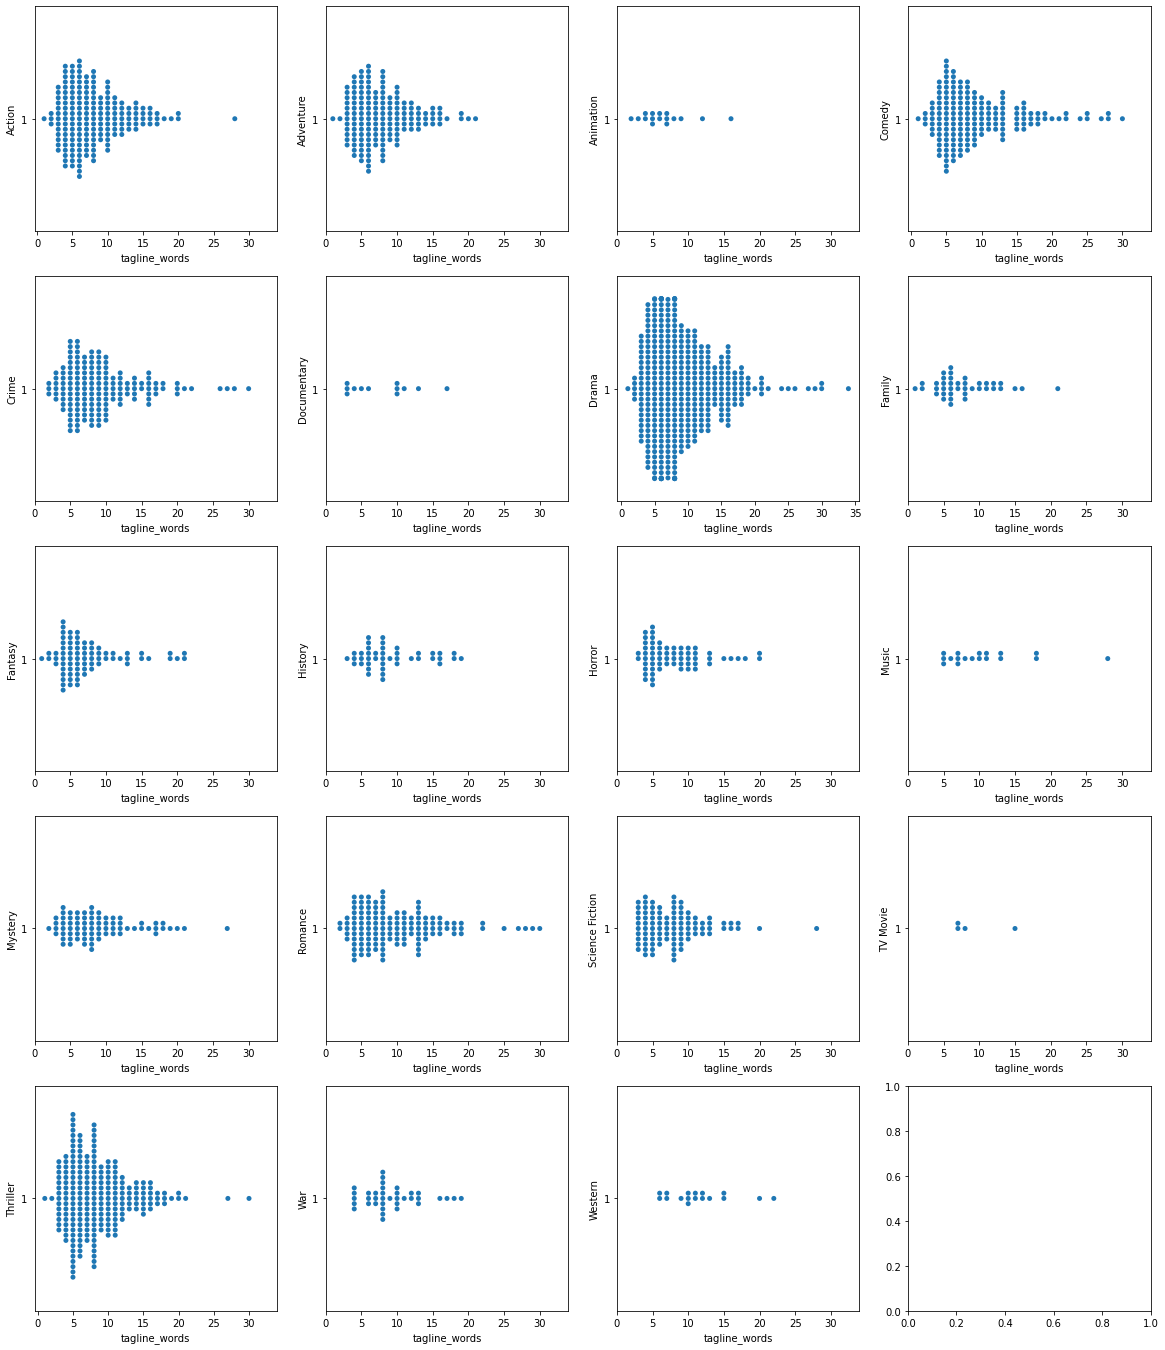

In [ ]:
# genre vs number of words in tagline

f, axes = plt.subplots(5, 4, figsize=(20, 24))

count = 0
for var in df_genre:
    df_tmp = df1.loc[df1[var] == 1].copy()
    df_tmp.loc[:,var] = df_tmp.loc[:,var].astype("category")
    
    ax1 = sb.swarmplot(x="tagline_words", y=var, data=df_tmp, ax=axes[int(count/4), int(count%4)])
    ax1.set_xticks(range(0,35))
    ax1.xaxis.set_major_locator(tc.MultipleLocator(5))
    ax1.xaxis.set_major_formatter(tc.ScalarFormatter())
    
    count = count+1

Tagline lengths seem generally consistent across the genres, with most of them featuring lengths of around 5-6 words. War and Western have above average tagline lengths, while Fantasy and Horror feature slightly below-average lengths.

### 'genre' vs Most-Frequent Words
Comparison of the top 5 most frequent words in the taglines for each genrem, after accounting for stopwords. This should give us an indication of the words we can expect to see when generating taglines.

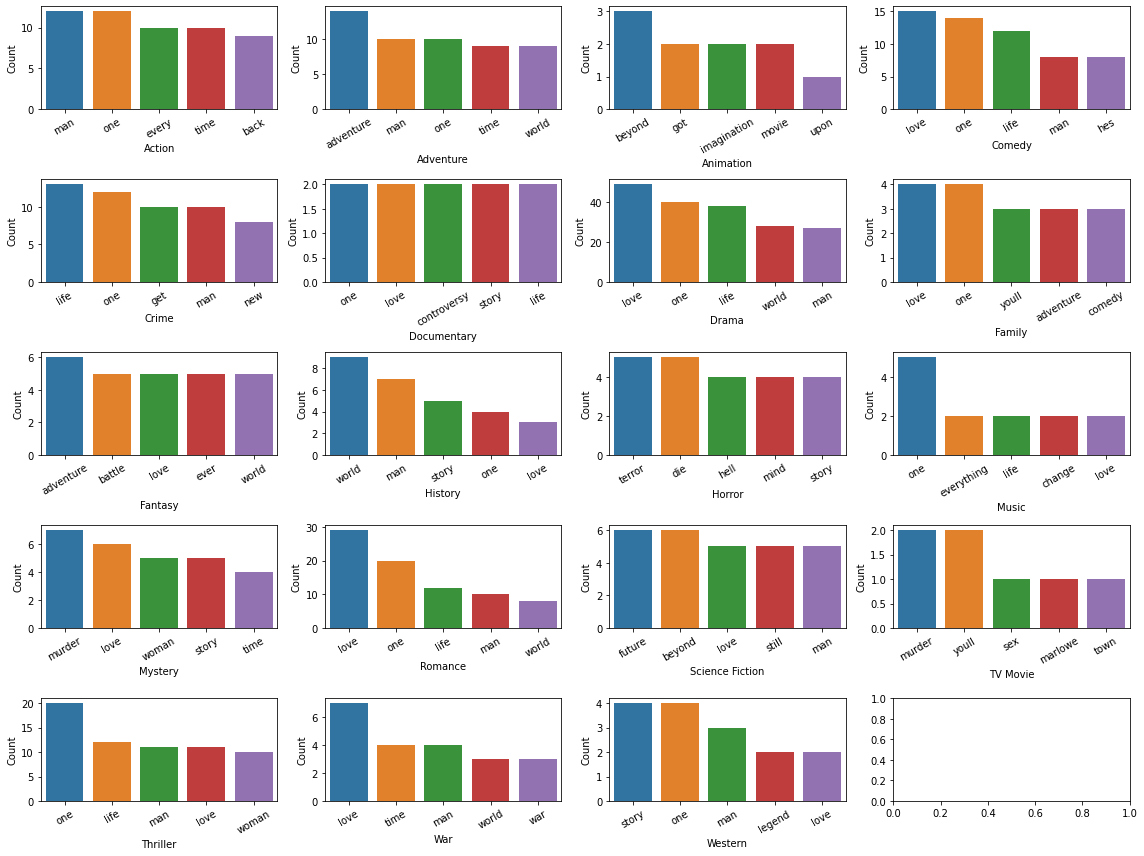

In [ ]:
# genre vs number of words in tagline

f, axes = plt.subplots(5, 4, figsize=(16, 12))
    
count = 0
for var in df_genre:
    df_tmp = df1[df1[var] == 1]
    g_top_5_sw = freq_words_sw(df_tmp, df_sw, 'tagline', 5)
    ax1 = sb.barplot(y="Count", x="Word", data=g_top_5_sw, ax=axes[int(count/4), int(count%4)])
    ax1.set(xlabel=var)
    plt.setp(ax1.get_xticklabels(), rotation=30)
    count = count+1

plt.tight_layout()

### 'release_date' vs 'tagline' length
Comparison of 'release_month' and 'release_year' against the number of words in the tagline for the movie. This could give an indication of the change in trends across time periods.

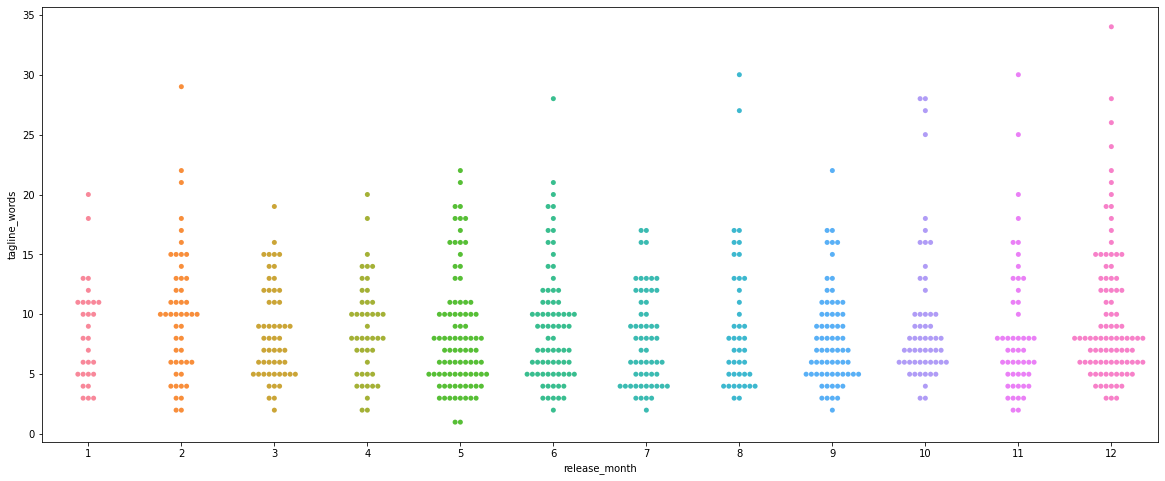

In [ ]:
# release month vs number of words in tagline

f = plt.figure(figsize=(20, 8))
ax2 = sb.swarmplot(x='release_month', y="tagline_words", data=df1)

It appears that movies released from May to September have generally lower tagline lengths than those released from November to February.

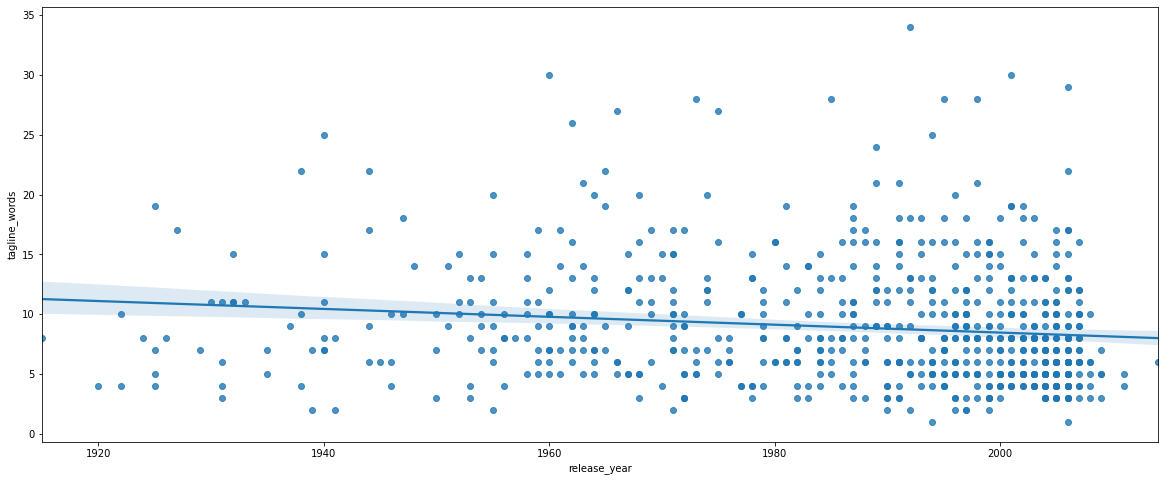

In [ ]:
# release year vs number of words in tagline

f = plt.figure(figsize=(20, 8))
df2 = df1[["release_year", "tagline_words"]].astype(float)
ax = sb.regplot(x='release_year',y='tagline_words', data=df2)

For the distribution across year, there is a slight negative correlation. We will bin the years in periods of 20 years and repeat the visualisation to confirm this observation.

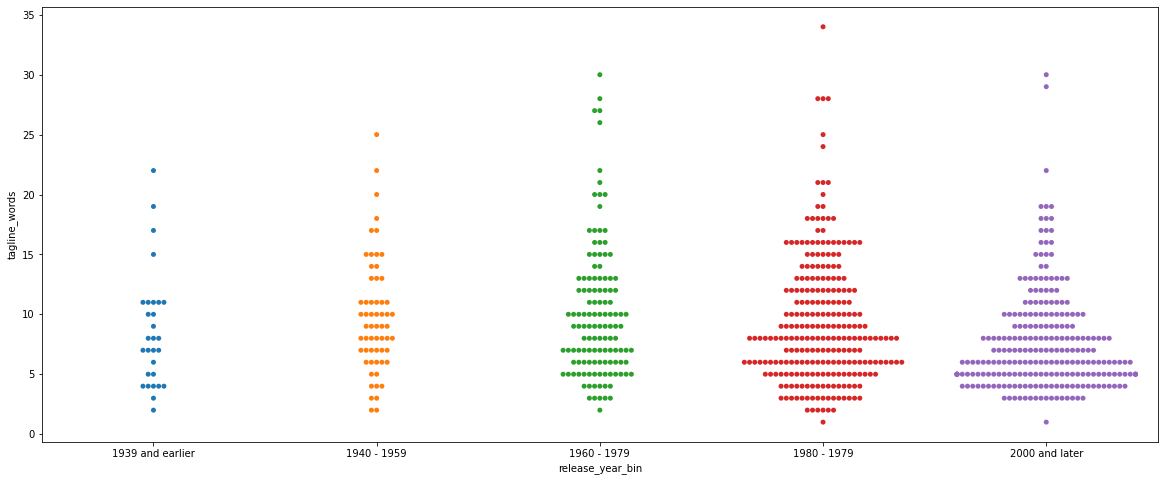

In [ ]:
# release_date binning

year_bins = ["1939 and earlier", "1940 - 1959", "1960 - 1979", "1980 - 1979", "2000 and later"]
df1['release_year_bin'] = ""

for i in range(len(df1)):
    tmpInt = df1.iloc[i, df1.columns.get_loc('release_year')]
    if (tmpInt <= 1939):
        df1.iloc[i, df1.columns.get_loc('release_year_bin')] = year_bins[0] # 1939 and earlier
    elif (tmpInt >= 1940 and tmpInt <= 1959):
        df1.iloc[i, df1.columns.get_loc('release_year_bin')] = year_bins[1] # 1940-1959
    elif (tmpInt >= 1960 and tmpInt <= 1979):
        df1.iloc[i, df1.columns.get_loc('release_year_bin')] = year_bins[2] # 1960-1979
    elif (tmpInt >= 1980 and tmpInt <= 1999):
        df1.iloc[i, df1.columns.get_loc('release_year_bin')] = year_bins[3] # 1979-1999
    elif (tmpInt >= 2000):
        df1.iloc[i, df1.columns.get_loc('release_year_bin')] = year_bins[4] # 2000 and later

# release month vs number of words in tagline

f = plt.figure(figsize=(20, 8))
ax2 = sb.swarmplot(x='release_year_bin', y="tagline_words", data=df1, order=year_bins)

There is a subtle trend that the length of tagline is decreasing, while the number of movies in each period is increasing, as seen in the flattening of the swarmplots with each period. Another observation is that far more movies appear to be released in more recent years.

### 'release_year_bin' vs Most-Frequent Words
Comparison of the most-frequent words in the tagline across periods of 20 years, after accounting for stopwords. While not entirely conclusive, we do notice that words such as 'love', 'story' and 'one' are continuously recurring across periods, and hence it might be reasonable to expect to see some of these words again in the predicted taglines. We also see some changes, such as the notable absence of 'love' in the the most recent period, which could signal a change in taste and preferences of movie audiences. 

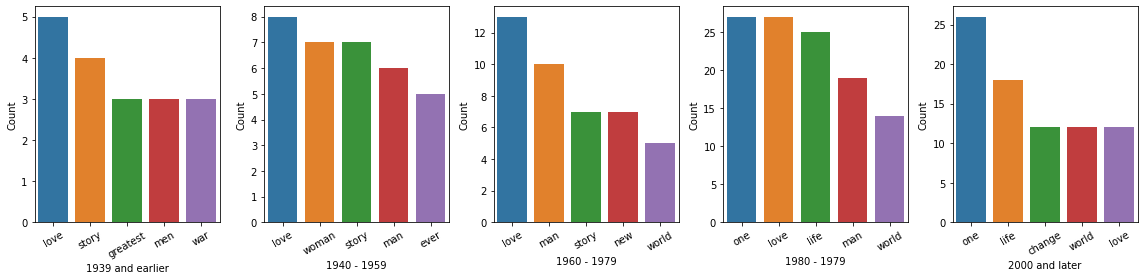

In [ ]:
f, axes = plt.subplots(1, 5, figsize=(16, 4))

count = 0
for var in year_bins:
    df_tmp = df1[df1["release_year_bin"] == var]
    r_top_5_sw = freq_words_sw(df_tmp, df_sw, 'tagline', 5)
    ax1 = sb.barplot(y="Count", x="Word", data=r_top_5_sw, ax = axes[count])
    ax1.set(xlabel=var)
    plt.setp(ax1.get_xticklabels(), rotation=30)
    count = count+1

plt.tight_layout()

### 'overview' length vs 'tagline' length
Comparison of the number of words in the overview against the number of words in the tagline for each movie.

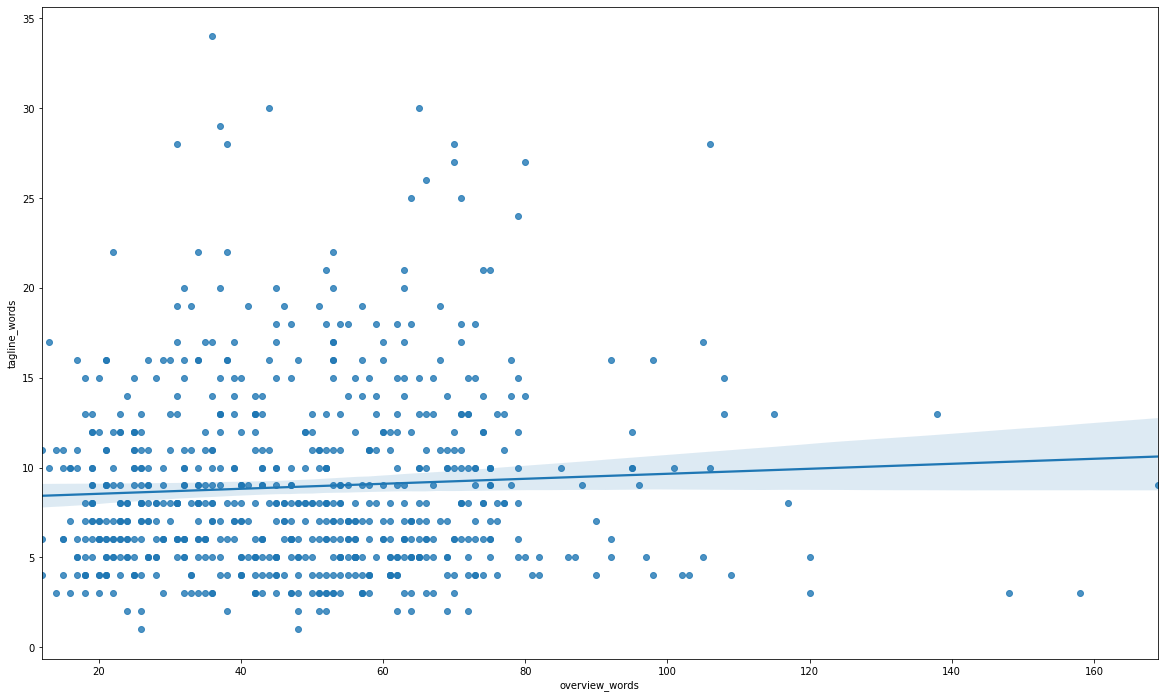

In [ ]:
# number of words in overview vs number of words in tagline

f = plt.figure(figsize=(20, 12))
ax = sb.regplot(x='overview_words',y='tagline_words', data=df1)

As seen from the regression line, there is little correlation between length of overview and length of tagline.